Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        6.7e+03 s    Elapsed time so far: 11.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        6.7e+03 s    Elapsed time so far: 11.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        6.7e+03 s    Elapsed time so far: 11.1 s


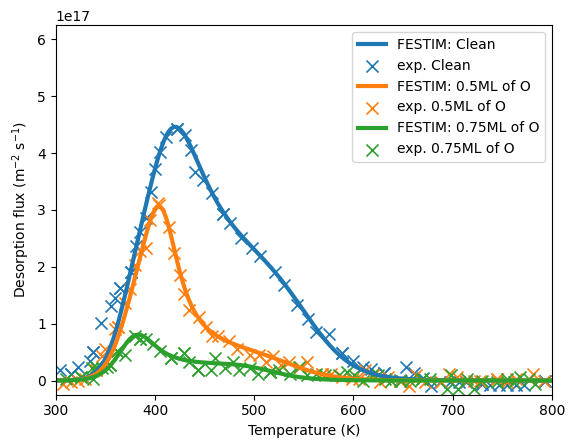

In [3]:
import festim as F
import fenics as f
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import warnings
global n_surf

warnings.filterwarnings("ignore")

################### PARAMETERS ###################
N_A_const = 6.022e23  # Avogadro, mol^-1
e = 1.602e-19
M_D2 = 4.028e-3 / N_A_const  # the D2 mass, kg mol^-1

# Exposure conditions
P_D2 = 2e-5  # Pa
T0 = 300  # K
ramp = 5  # K/s
t_imp = 3000  # exposure duration, s
t_storage = 3600  # storage time, s
t_TDS = 100  # s
L = 2e-3 / 2  # half thickness, m

# W properties
rho_W = 6.3382e28  # W atomic concentration, m^-3
n_IS = 6 * rho_W  # concentration of interstitial sites, m^-3
n_surf = 1.416e19  # concentration of adsorption sites, m^-2

nu0 = 1e13  # attempt frequency, s^-1

D0 = 1.9e-7 / np.sqrt(2)  # diffusivity pre-factor, m^2 s^-1
E_diff = 0.2  # diffusion activation energy, eV

# Transitions
E_bs = E_diff  # energy barrier from bulk to surface, eV
E_diss = 0  # energy barrier for D2 dissociation, eV
Q_sol = 1  # heat of solution, eV

# Fitting parameters
fits = {
    "E0": [1.142, 1.111, 1.066],
    "dE": [0.346, 0.289, 0.234],
    "theta_D0": [0.253, 0.113, 0.161],
    "dtheta_D": [0.180, 0.082, 0.057],
    "alpha": [0.303, 0.460, 0.437],
    "beta": [8.902, 7.240, 4.144]
}
################### FUNCTIONS ###################



################### MODEL ###################
colors = ["tab:blue", "tab:red", "tab:green"]
names = ["000O", "050O", "075O"]
labels = ["Clean", "0.5ML of O", "0.75ML of O"]
n_surfs = [n_surf, n_surf*(1-0.5), n_surf*(1-0.75)]
for i in range(3):
    n_surf = n_surfs[i]
    lamda_des = 1 / np.sqrt(n_surf)  # average distance between adsorption sites, m
    lambda_abs = n_surf / n_IS  # distance between subsurface IS and adsorption sites, m

    def E_des(surf_conc):
        theta_D = surf_conc / n_surf
        theta_D0 = fits["theta_D0"][i] #0.253
        del_theta_D = fits["dtheta_D"][i] #0.180
        E0 = fits["E0"][i] #1.142
        dE = fits["dE"][i] #0.346
        alpha = fits['alpha'][i] #0.303
        beta = fits['beta'][i] #8.902

        E_FD = E0 + dE / (1 + f.exp((theta_D - theta_D0) / del_theta_D))
        E_des = E_FD * (1 - alpha * f.exp(-beta * (1 - theta_D)))
        return E_des

    def S0(T):
        # the capturing coefficient
        return f.exp(-E_diss / F.k_B / T)


    def E_sb(surf_conc):
        # energy barrier from surface to bulk, eV
        return (E_des(surf_conc) - E_diss) / 2 + E_bs + Q_sol

    def K_sb(surf_conc, T, t):
        return nu0 * f.exp(-E_sb(surf_conc)/F.k_B/T)

    def K_bs(surf_conc, T, t):
        return nu0 * f.exp(-E_bs/F.k_B/T)
   
    def J_vs(surf_conc, T, t):
        J_ads = (
            2
            * S0(T)
            * (1 - surf_conc / n_surf) ** 2
            * f.conditional(t <= t_imp, 1.52e18, 0)
        )

        J_des = (
            2 * nu0 * (lamda_des * surf_conc) ** 2 * f.exp(-E_des(surf_conc) / F.k_B / T)
        )
        return J_ads - J_des

    W_model = F.Simulation(log_level=40)

    # Mesh
    vertices = np.linspace(0, L, num=500)
    W_model.mesh = F.MeshFromVertices(np.sort(vertices))

    # Materials
    tungsten = F.Material(id=1, D_0=D0, E_D=E_diff)
    W_model.materials = tungsten

    surf_conc = F.SurfaceConcentration(
        k_sb=K_sb,
        k_bs=K_bs,
        l_abs=lambda_abs,
        N_s=n_surf,
        N_b=n_IS,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=F.InitialCondition(field="adsorbed", value=0),
        t=F.t,
    )

    W_model.surface_concentrations = [surf_conc]

    traps = F.Traps(
        [
            F.Trap(
                k_0=nu0 / n_IS,
                E_k=E_diff,
                p_0=nu0,
                E_p=0.912,
                density=7.7e-6,
                materials=tungsten,
            ),
            F.Trap(
                k_0=nu0 / n_IS,
                E_k=E_diff,
                p_0=nu0,
                E_p=1.176,
                density=7.9e-7,
                materials=tungsten,
            ),
        ]
    )
    #W_model.traps = traps

    W_model.T = F.Temperature(
        value=sp.Piecewise(
            (T0, F.t < t_imp + t_storage), (T0 + ramp * (F.t - t_imp - t_storage), True)
        )
    )

    W_model.dt = F.Stepsize(
        initial_value=1e-7,
        stepsize_change_ratio=1.25,
        max_stepsize=lambda t: 10 if t < t_imp + t_storage-10 else 0.5,
        dt_min=1e-9,
    )

    W_model.settings = F.Settings(
        absolute_tolerance=1e8,
        relative_tolerance=1e-7,
        maximum_iterations=50,
        final_time=t_imp + t_storage + t_TDS,
    )

    # Exports
    results_folder = "./results/"

    derived_quantities = F.DerivedQuantities(
        [F.AdsorbedHydrogen(surface=1), F.TotalSurface(field="T", surface=1)],
        nb_iterations_between_compute=1,
        filename=results_folder + names[i] + ".csv",
    )

    W_model.exports = [derived_quantities]

    W_model.initialise()
    W_model.run()

    results = pd.read_csv(results_folder + names[i] + ".csv", header=0)
    results["Flux"] = results["Concentration of adsorbed H on surface 1"]
    for j in range(len(results)):
        surf_conc = results["Concentration of adsorbed H on surface 1"][j]
        T = results["Total T surface 1"][j]
        results["Flux"][j] = (
            2 * nu0 * (lamda_des * surf_conc) ** 2 * np.exp(-E_des(surf_conc) / F.k_B / T)
        )


    plt.plot(
        results["Total T surface 1"][results["t(s)"] >= t_imp + t_storage],
        results["Flux"][results["t(s)"] >= t_imp + t_storage],
        linewidth=3,
        label='FESTIM: '+labels[i],
    )

    exp = pd.read_csv(f"./exp_data/"+names[i]+".csv", header=None, skiprows=1, sep=",")
    plt.scatter(exp[0], exp[1], marker="x", s=75, linewidths=1.2, label = "exp. "+labels[i])

plt.ylabel(r"Desorption flux (m$^{-2}$ s$^{-1}$)")
plt.xlabel(r"Temperature (K)")
plt.legend()
plt.ylim(-0.25e17, 6.25e17)
plt.xlim(300, 800)
plt.show()